# hillmaker - OO design ideas

https://github.com/misken/hillmaker/tree/develop

**TODO - Add material from previous explainer notebooks that covers horizon, warmup, use of CLI details and more.**

Overall application design goals and objectives

- should be easy to run a scenario and get all the standard outputs
- scenario specific settings should be persistable as something like a json file
- should be possible to generate only outputs wanted
- should have a CLI
- should be importable so that it can be used from notebook or other custom Python scripts
- be nice to have a GUI for non-technie users
- should be easy to explore multiple scenarios
- global and scenario specific settings can be managed through settings files, command line args or function args
- current occupancy, arrival and departure stats all still desirable
- los summary would be nice
- outputs should be in formats that lend themselves to further analysis and reporting such as csvs for the occ stats (bydatetime and summary), standard graphic file formats, perhaps JSON for los summary and occ stats
- dataset profiling should be done to identify potential issues with horizon effects, warmup effects, missing data periods, or other anomolies.


Should hillmaker be redesigned as an OO based application?

- does OO design make for a better analyst experience? For example, does OO make it easier to create and manage a bunch of scenarios in which each is a separate hillmaker run? OO would make it easier to document scenarios through their settings (e.g. as json file).
- does OO lead to potential performance gains by making it easier to only run the parts we want to run. For example, maybe we don't want individual day of week plots.
- right now hillmaker is an (almost) all or nothing experience with each run standing alone. 
- OO would likely be better for those using hillmaker programmatically. 
- no matter what the design, there will always be a CLI.
- not sure how OO or not affects GUI dev

How should hillmaker be redesigned as an OO based application?

## Use case 1 - overall and by patient type summaries

Patients flow through a short stay unit for a variety of procedures, tests or therapies. Let's assume patients can be classified into one of five categories of patient types: ART (arterialgram), CAT (post cardiac-cath), MYE (myelogram), IVT (IV therapy), and OTH (other). From one of our hospital information systems we were able to get raw data about the entry and exit times of each patient and exported the data to a csv file. We call each row of such data a *stop* (as in, the patient stopped here for a while). 

- We want to generate summaries of occupancy as well as arrivals and discharges to go into a summary report for hospital administration. 
- We want these overall and by patient type. 
- We also want LOS summaries by patient type. 
- Volume and occupancy trends over time

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from pathlib import Path
from pprint import pprint

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from IPython.display import Image

from datetime import datetime, date
from typing import Dict, List, Optional, Tuple, Union

In [4]:
ssu_stopdata = '../data/ShortStay.csv'
ssu_stops_df = pd.read_csv(ssu_stopdata, parse_dates=['InRoomTS','OutRoomTS'])
ssu_stops_df.info() # Check out the structure of the resulting DataFrame

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59877 entries, 0 to 59876
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   PatID      59877 non-null  int64         
 1   InRoomTS   59877 non-null  datetime64[ns]
 2   OutRoomTS  59877 non-null  datetime64[ns]
 3   PatType    59877 non-null  object        
dtypes: datetime64[ns](2), int64(1), object(1)
memory usage: 1.8+ MB


In [5]:
ssu_stops_df.head()

,PatID,InRoomTS,OutRoomTS,PatType
0,1,1996-01-01 07:44:00,1996-01-01 08:50:00,IVT
1,2,1996-01-01 08:28:00,1996-01-01 09:20:00,IVT
2,3,1996-01-01 11:44:00,1996-01-01 13:30:00,MYE
3,4,1996-01-01 11:51:00,1996-01-01 12:55:00,CAT
4,5,1996-01-01 12:10:00,1996-01-01 13:00:00,IVT


## An OO version of hillmaker (0.5.0)

This is a work in progress and just wanted to share some early ideas. To summarize:

- added a `Scenario` class which has methods for running hillmaker (`make_hills()`) and for retrieving plots and dataframes from the results dictionary (`get_plot()`, `get_summary_df()`, and `get_bydatetime_df()`). 
- the plots and dataframes produced by `make_hills` are stored in a dictionary called `hills` that is an attribute of the `Scenario` class
- the methods of the `Scenario` class are just wrappers that call module level functions of the same name that do the actual work. By doing this, I haven't broken the existing hillmaker API - you can still call a `make_hills` function and pass in a bunch of key word arguments and run things. The `make_hills()` function returns a `hills` dictionary and `get_plot` and `get_*_df` functions can be used to extract plots and dataframes from `hills` in a simple way.
- the `Scenario` class is actually a `pydantic` model which handles input validation.

So, hillmaker can be used in either an objected oriented way or a via standard function calls. It also has (or will have) a CLI. For now, this lets us try it out and see what makes the most sense for future development.

## Usage example 1 - the OO approach

In [6]:
import hillmaker as hm

Here are a collection of inputs that we'll use to create a scenario. Notice I purposely set one of the input dates to a string and the other to a `Timestamp` just to show that the `pydantic` model can handle the automatic transformation for us to a `datetime`.

In [7]:
# Required inputs
scenario_name = 'ssu_1'
stops_df = ssu_stops_df
in_field_name = 'InRoomTS'
out_field_name = 'OutRoomTS'
start_date = '1996-01-01'
end_date = pd.Timestamp('9/30/1996')

# Optional inputs

cat_field_name = 'PatType'
verbosity = 1 # INFO level logging
output_path = './output'
bin_size_minutes = 60

I created a `Scenario` class that is a Pydantic model. It handles a bunch of type constraints, validation, and default values. What does the `Scenario` class look like?

In [8]:
hm.Scenario?

Init signature:
hm.Scenario(
    *,
    scenario_name: str,
    stops_df: pandas.core.frame.DataFrame,
    in_field: str,
    out_field: str,
    start_analysis_dt: datetime.date | datetime.datetime | pandas._libs.tslibs.timestamps.Timestamp | numpy.datetime64,
    end_analysis_dt: datetime.date | datetime.datetime | pandas._libs.tslibs.timestamps.Timestamp | numpy.datetime64,
    cat_field: str | None = None,
    bin_size_minutes: int = 60,
    cats_to_exclude: Optional[List[str]] = None,
    occ_weight_field: str | None = None,
    percentiles: Union[Tuple[Annotated[float, None, Interval(gt=None, ge=0.0, lt=None, le=1.0), None, None]], List[Annotated[float, None, Interval(gt=None, ge=0.0, lt=None, le=1.0), None, None]]] = (0.25, 0.5, 0.75, 0.95, 0.99),
    nonstationary_stats: bool = True,
    stationary_stats: bool = True,
    edge_bins: hillmaker.scenario.EdgeBinsEnum = <EdgeBinsEnum.FRACTIONAL: 1>,
    output_path: str | pathlib.Path = PosixPath('.'),
    export_bydatetime_csv: bo

We can create scenarios a few different ways.

- instantiate an instance of `Scenario` by passing in keyword args
- if the args are in a dict, can use dictionary unpacking to do the same
- there's a `create_scenario` function in the `utils` module that can take any of a dict, a TOML path or keyword args and returns a `Scenario` object (precedence is in the reverse order - kwargs get the final say)

### Create a new scenario with keyword arguments

You can create an instance of `Scenario` by passing in keyword arguments.

In [9]:
scenario_1 = hm.Scenario(scenario_name=scenario_name, 
                         stops_df=stops_df,
                         in_field=in_field_name,
                         out_field=out_field_name,
                         start_analysis_dt=start_date,
                         end_analysis_dt=end_date,
                         cat_field=cat_field_name,
                         output_path=Path('./output'),
                         verbosity=verbosity)

In [10]:
pprint(scenario_1.model_dump())

{'bin_size_minutes': 60,
 'cap': None,
 'cat_field': 'PatType',
 'cats_to_exclude': None,
 'edge_bins': <EdgeBinsEnum.FRACTIONAL: 1>,
 'end_analysis_dt': numpy.datetime64('1996-09-30T00:00:00.000000000'),
 'export_all_dow_plots': False,
 'export_all_week_plots': False,
 'export_bydatetime_csv': False,
 'export_summaries_csv': False,
 'hills': None,
 'in_field': 'InRoomTS',
 'make_all_dow_plots': True,
 'make_all_week_plots': True,
 'nonstationary_stats': True,
 'occ_weight_field': None,
 'out_field': 'OutRoomTS',
 'output_path': PosixPath('output'),
 'percentiles': (0.25, 0.5, 0.75, 0.95, 0.99),
 'scenario_name': 'ss_example_1',
 'start_analysis_dt': numpy.datetime64('1996-01-01T00:00:00.000000000'),
 'stationary_stats': True,
 'stops_df':        PatID            InRoomTS           OutRoomTS PatType
0          1 1996-01-01 07:44:00 1996-01-01 08:50:00     IVT
1          2 1996-01-01 08:28:00 1996-01-01 09:20:00     IVT
2          3 1996-01-01 11:44:00 1996-01-01 13:30:00     MYE
3     

You can use pydantic's `model_dump` function to create dictionary from a pydantic model. I'll do that and make a few changes and create a new scenario from the modified dict using dictionary unpacking to pass in the keyword arguments to `Scenario`.

In [11]:
# Dump pydantic model to dict (could wrap this with a to_dict() method
scenario_2_dict = scenario_1.model_dump()

# Make some changes
scenario_2_dict['scenario_name'] = 'ssu_2'
scenario_2_dict['bin_size_minutes'] = 30

# Make a new scenario using dictionary unpacking
scenario_2 = hm.Scenario(**scenario_2_dict)

pprint(scenario_2)

Scenario(scenario_name='ss_example_2', stops_df=       PatID            InRoomTS           OutRoomTS PatType
0          1 1996-01-01 07:44:00 1996-01-01 08:50:00     IVT
1          2 1996-01-01 08:28:00 1996-01-01 09:20:00     IVT
2          3 1996-01-01 11:44:00 1996-01-01 13:30:00     MYE
3          4 1996-01-01 11:51:00 1996-01-01 12:55:00     CAT
4          5 1996-01-01 12:10:00 1996-01-01 13:00:00     IVT
...      ...                 ...                 ...     ...
59872  59873 1996-09-30 19:31:00 1996-09-30 20:15:00     IVT
59873  59874 1996-09-30 20:23:00 1996-09-30 21:30:00     IVT
59874  59875 1996-09-30 21:00:00 1996-09-30 22:45:00     CAT
59875  59876 1996-09-30 21:57:00 1996-09-30 22:40:00     IVT
59876  59877 1996-09-30 22:45:00 1996-09-30 23:35:00     CAT

[59877 rows x 4 columns], in_field='InRoomTS', out_field='OutRoomTS', start_analysis_dt=numpy.datetime64('1996-01-01T00:00:00.000000000'), end_analysis_dt=numpy.datetime64('1996-09-30T00:00:00.000000000'), cat_field='Pa

Since the scenario objects are really just a Python class, attributes can be get and set in the usual way.

### Create a new scenario with a TOML config file

To use a TOML configuration file to create a scenario, we can use the `create_scenario` function in the `utils` module.
Notice here that instead of specifying a pandas `DataFrame`, we are specifiying a path to a csv file which will be read to create the stops `DataFrame`. It would be also possible to allow a string corresponding to the name of an existing `DataFrame` to be specified - we could use the `globals()[<string_name_of_dataframe>]` construct to access the actual object.

Here's an example config file:

```
[scenario_data]
scenario_name = "ssu_3"
stop_data_csv = "../data/ShortStay.csv"

[fields]
in_field = "InRoomTS"
out_field = "OutRoomTS"
# Just remove the following line if no category field
cat_field = "PatType"

[analysis_dates]
start_analysis_dt = 1996-01-01
end_analysis_dt = 1996-09-30

[settings]
bin_size_minutes = 60
verbosity = 1
output_path = "./output"

# Add any additional arguments here
# Strings should be surrounded in double quotes
# Floats and ints are specified in the normal way as values
# Dates are specified as shown above

# For arguments that take lists, the entries look
# just like Python lists and following the other rules above

# cats_to_exclude = ["IVT", "OTH"]
# percentiles = [0.5, 0.8, 0.9]
```

In [12]:
config_file = Path('ssu_3.toml')
scenario_3 = hm.create_scenario(toml_path=config_file)
print(scenario_3)

{'scenario_name': 'ss_example_3', 'stops_df':        PatID            InRoomTS           OutRoomTS PatType
0          1 1996-01-01 07:44:00 1996-01-01 08:50:00     IVT
1          2 1996-01-01 08:28:00 1996-01-01 09:20:00     IVT
2          3 1996-01-01 11:44:00 1996-01-01 13:30:00     MYE
3          4 1996-01-01 11:51:00 1996-01-01 12:55:00     CAT
4          5 1996-01-01 12:10:00 1996-01-01 13:00:00     IVT
...      ...                 ...                 ...     ...
59872  59873 1996-09-30 19:31:00 1996-09-30 20:15:00     IVT
59873  59874 1996-09-30 20:23:00 1996-09-30 21:30:00     IVT
59874  59875 1996-09-30 21:00:00 1996-09-30 22:45:00     CAT
59875  59876 1996-09-30 21:57:00 1996-09-30 22:40:00     IVT
59876  59877 1996-09-30 22:45:00 1996-09-30 23:35:00     CAT

[59877 rows x 4 columns], 'in_field': 'InRoomTS', 'out_field': 'OutRoomTS', 'start_analysis_dt': numpy.datetime64('1996-01-01T00:00:00.000000000'), 'end_analysis_dt': numpy.datetime64('1996-09-30T00:00:00.000000000'), 'ca

In [13]:
scenario_1.bin_size_minutes

60

While this is convenient, it does mean that as the programmer, you can get around some of the validation checks that were already done. For example, `bin_size_minutes` must evenly divide into 1440. I can add code to revalidate the model before allowing `make_hills` to run but I'm not going to bother for now. The standard Python error system will catch bad things.

In [14]:
# Bad
scenario_1.bin_size_minutes = 17

# Set it back to a valid value
scenario_1.bin_size_minutes = 60

### Create a new scenario using `create_scenario()` and a dictionary

The `create_scenario` function also can take, as input, a dictionary of input arguments. Notice in the example below that I've used strings for the dates but I could just as well have used `datetime` or `TimeStamp` objects - anything that can be converted to a pandas `TimeStamp` is allowed. I've only included the required parameters and two optional parameters - `cat_field` and `bin_size_mins`.

```
scenario_4_dict = {
    'scenario_name': 'ssu_4',
    'stops_df': ssu_stops_df,
    'in_field': 'InRoomTS',
    'out_field': 'OutRoomTS',
    'start_analysis_dt': '1996-01-01',
    'end_analysis_dt': '1996-09-30',
    'cat_field': 'PatType',
    'bin_size_minutes': 60
}
```

In [15]:
hm.create_scenario?

Signature:
hm.create_scenario(
    params_dict: Optional[Dict] = None,
    toml_path: Union[str, pathlib.Path, NoneType] = None,
    **kwargs,
)
Docstring: Function to create a `Scenario` from a dict, a TOML file, and/or keyword args 
File:      ~/Documents/projects/hillmaker/src/hillmaker/utils.py
Type:      function

In [16]:
scenario_4_dict = {
    'scenario_name': 'ssu_4',
    'stops_df': ssu_stops_df,
    'in_field': 'InRoomTS',
    'out_field': 'OutRoomTS',
    'start_analysis_dt': '1996-01-01',
    'end_analysis_dt': '1996-09-30',
    'cat_field': 'PatType',
    'bin_size_minutes': 60
}

scenario_4 = hm.create_scenario(params_dict=scenario_4_dict)
print(scenario_4)


{'scenario_name': 'ss_example_4', 'stops_df':        PatID            InRoomTS           OutRoomTS PatType
0          1 1996-01-01 07:44:00 1996-01-01 08:50:00     IVT
1          2 1996-01-01 08:28:00 1996-01-01 09:20:00     IVT
2          3 1996-01-01 11:44:00 1996-01-01 13:30:00     MYE
3          4 1996-01-01 11:51:00 1996-01-01 12:55:00     CAT
4          5 1996-01-01 12:10:00 1996-01-01 13:00:00     IVT
...      ...                 ...                 ...     ...
59872  59873 1996-09-30 19:31:00 1996-09-30 20:15:00     IVT
59873  59874 1996-09-30 20:23:00 1996-09-30 21:30:00     IVT
59874  59875 1996-09-30 21:00:00 1996-09-30 22:45:00     CAT
59875  59876 1996-09-30 21:57:00 1996-09-30 22:40:00     IVT
59876  59877 1996-09-30 22:45:00 1996-09-30 23:35:00     CAT

[59877 rows x 4 columns], 'in_field': 'InRoomTS', 'out_field': 'OutRoomTS', 'start_analysis_dt': numpy.datetime64('1996-01-01T00:00:00.000000000'), 'end_analysis_dt': numpy.datetime64('1996-09-30T00:00:00.000000000'), 'ca

With `create_scenario`, you can also include keyword arguments that will take precedence over those specified in either a TOML file or a dictionary. 

In [17]:
scenario_5_dict = {
    'scenario_name': 'ssu_5',
    'stops_df': ssu_stops_df,
    'in_field': 'InRoomTS',
    'out_field': 'OutRoomTS',
    'start_analysis_dt': '1996-01-01',
    'end_analysis_dt': '1996-09-30',
    'cat_field': 'PatType',
    'bin_size_minutes': 60
}

scenario_5 = hm.create_scenario(params_dict=scenario_5_dict, 
                                export_all_week_plots=True, bin_size_minutes=30)
print(scenario_5)

{'scenario_name': 'ss_example_5', 'stops_df':        PatID            InRoomTS           OutRoomTS PatType
0          1 1996-01-01 07:44:00 1996-01-01 08:50:00     IVT
1          2 1996-01-01 08:28:00 1996-01-01 09:20:00     IVT
2          3 1996-01-01 11:44:00 1996-01-01 13:30:00     MYE
3          4 1996-01-01 11:51:00 1996-01-01 12:55:00     CAT
4          5 1996-01-01 12:10:00 1996-01-01 13:00:00     IVT
...      ...                 ...                 ...     ...
59872  59873 1996-09-30 19:31:00 1996-09-30 20:15:00     IVT
59873  59874 1996-09-30 20:23:00 1996-09-30 21:30:00     IVT
59874  59875 1996-09-30 21:00:00 1996-09-30 22:45:00     CAT
59875  59876 1996-09-30 21:57:00 1996-09-30 22:40:00     IVT
59876  59877 1996-09-30 22:45:00 1996-09-30 23:35:00     CAT

[59877 rows x 4 columns], 'in_field': 'InRoomTS', 'out_field': 'OutRoomTS', 'start_analysis_dt': numpy.datetime64('1996-01-01T00:00:00.000000000'), 'end_analysis_dt': numpy.datetime64('1996-09-30T00:00:00.000000000'), 'ca

Now let's generate hills by using the `make_hills` method of one of the scenario instances.

In [18]:
scenario_1.make_hills()

2023-08-23 19:30:50,726 - hillmaker.bydatetime - INFO - min of intime: 1996-01-01 07:44:00
2023-08-23 19:30:50,727 - hillmaker.bydatetime - INFO - max of intime: 1996-09-29 19:51:00
2023-08-23 19:30:50,728 - hillmaker.bydatetime - INFO - min of outtime: 1996-01-01 08:50:00
2023-08-23 19:30:50,729 - hillmaker.bydatetime - INFO - max of outtime: 1996-09-29 20:15:00
2023-08-23 19:30:50,730 - hillmaker.bydatetime - INFO - start analysis: 1996-01-01, end analysis: 1996-09-30
2023-08-23 19:30:50,762 - hillmaker.bydatetime - INFO - min of entry time_bin = 7
2023-08-23 19:30:50,765 - hillmaker.bydatetime - INFO - max of exit time_bin = 6546 and num_bins=6553
2023-08-23 19:30:51,438 - hillmaker.bydatetime - INFO - cat IVT {'inner': 33019}
2023-08-23 19:30:51,485 - hillmaker.bydatetime - INFO - cat IVT num_arrivals_hm 33019 num_arrivals_stops 33019
2023-08-23 19:30:51,486 - hillmaker.bydatetime - INFO - cat IVT num_departures_hm 33019 num_departures_stops 33019
2023-08-23 19:30:51,489 - hillmake

All of the outputs get stored in the `hills` dictionary attribute. It's a nested dictionary and it can be cumbersome to pull out specific items. Later in this notebook we'll describe "getter" methods to make it easier to pull out specific plots or dataframes.

In [19]:
scenario_1.hills.keys()

dict_keys(['bydatetime', 'summaries', 'settings', 'plots'])

In [20]:
scenario_1.hills['bydatetime'].keys()

dict_keys(['PatType_datetime', 'datetime'])

In [21]:
scenario_1.hills['bydatetime']['PatType_datetime'].head()

arrivals  departures  occupancy  day_of_week  \
PatType datetime                                                            
ART     1996-01-01 00:00:00       0.0         0.0        0.0            0   
        1996-01-01 01:00:00       0.0         0.0        0.0            0   
        1996-01-01 02:00:00       0.0         0.0        0.0            0   
        1996-01-01 03:00:00       0.0         0.0        0.0            0   
        1996-01-01 04:00:00       0.0         0.0        0.0            0   

                            dow_name bin_of_day_str  bin_of_day  bin_of_week  
PatType datetime                                                              
ART     1996-01-01 00:00:00      Mon          00:00           0            0  
        1996-01-01 01:00:00      Mon          01:00           1            1  
        1996-01-01 02:00:00      Mon          02:00           2            2  
        1996-01-01 03:00:00      Mon          03:00           3            3  
        1996-01-01 04:00:00      Mon          04:00           4            4

In [22]:
scenario_1.hills['summaries'].keys()

dict_keys(['nonstationary', 'stationary'])

In [23]:
scenario_1.hills['summaries']['nonstationary'].keys()

dict_keys(['PatType_dow_binofday', 'dow_binofday'])

In [24]:
scenario_1.hills['summaries']['nonstationary']['PatType_dow_binofday'].keys()

dict_keys(['occupancy', 'arrivals', 'departures'])

In [25]:
scenario_1.hills['summaries']['nonstationary']['PatType_dow_binofday']['occupancy'].head()

count  mean  min  max  \
PatType day_of_week dow_name bin_of_day bin_of_day_str                          
ART     0           Mon      0          00:00            40.0   0.0  0.0  0.0   
                             1          01:00            39.0   0.0  0.0  0.0   
                             2          02:00            39.0   0.0  0.0  0.0   
                             3          03:00            39.0   0.0  0.0  0.0   
                             4          04:00            39.0   0.0  0.0  0.0   

                                                        stdev  sem  var   cv  \
PatType day_of_week dow_name bin_of_day bin_of_day_str                         
ART     0           Mon      0          00:00             0.0  0.0  0.0  0.0   
                             1          01:00             0.0  0.0  0.0  0.0   
                             2          02:00             0.0  0.0  0.0  0.0   
                             3          03:00             0.0  0.0  0.0  0.0   
                             4          04:00             0.0  0.0  0.0  0.0   

                                                        skew  kurt  p25  p50  \
PatType day_of_week dow_name bin_of_day bin_of_day_str                         
ART     0           Mon      0          00:00            0.0   0.0  0.0  0.0   
                             1          01:00            0.0   0.0  0.0  0.0   
                             2          02:00            0.0   0.0  0.0  0.0   
                             3          03:00            0.0   0.0  0.0  0.0   
                             4          04:00            0.0   0.0  0.0  0.0   

                                                        p75  p95  p99  
PatType day_of_week dow_name bin_of_day bin_of_day_str                 
ART     0           Mon      0          00:00           0.0  0.0  0.0  
                             1          01:00           0.0  0.0  0.0  
                             2          02:00           0.0  0.0  0.0  
                             3          03:00           0.0  0.0  0.0  
                             4          04:00           0.0  0.0  0.0

In [26]:
scenario_1.hills['settings']

{'scenario_name': 'ss_example_1', 'cat_field': 'PatType'}

## Retrieving specific plots and/or DataFrames

As previously pointed out, it's clunky to have to traverse these dictionaries to pull out plots and dataframes. Seems like we'd want to be able to quickly view a specific plot or `DataFrame`.

Methods `get_plot()` and `get_dataframe()` were added the `Scenario` class. These are actually just wrappers for module level functions `hills.get_plot()` and `hills.get_dataframe()`.

In [33]:
scenario_1.get_plot??

Signature:
scenario_1.get_plot(
    flow_metric: str = 'occupancy',
    day_of_week: str = 'week',
)
Source:   
    def get_plot(self, flow_metric: str = 'occupancy', day_of_week: str = 'week'):
        """
        Get plot object for specified flow metric and whether full week or specified day of week.

        Parameters
        ----------
        flow_metric : str
            Either of 'arrivals', 'departures', 'occupancy' ('a', 'd', and 'o' are sufficient).
            Default='occupancy'
        day_of_week : str
            Either of 'week', 'Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat'. Default='week'

        Returns
        -------
        plot object from matplotlib

        """

        plot = get_plot(self.hills, flow_metric, day_of_week)
        return plot
File:      ~/Documents/projects/hillmaker/src/hillmaker/scenario.py
Type:      method

In [ ]:
plot = scenario_1.get_plot('occupancy')

In [ ]:
plot

In [ ]:
scenario_1.get_plot('occ')

In [ ]:
scenario_1.get_plot('departures', 'Mon')

In [28]:
scenario_2.get_summary_df?

Signature:
scenario_2.get_summary_df(
    flow_metric: str = 'occupancy',
    by_category: bool = True,
    stationary: bool = False,
)
Docstring:
Get summary dataframe

Parameters
----------
flow_metric : str
    Either of 'arrivals', 'departures', 'occupancy' ('a', 'd', and 'o' are sufficient).
    Default='occupancy'
by_category : bool
    Default=True corresponds to category specific statistics. A value of False gives overall statistics.
stationary : bool
    Default=False corresponds to the standard nonstationary statistics (i.e. by TOD and DOW)

Returns
-------
DataFrame
File:      ~/Documents/projects/hillmaker/src/hillmaker/scenario.py
Type:      method

In [29]:
occ_summary_df = scenario_1.get_summary_df('o')
occ_summary_df

count  mean  min  max  \
PatType day_of_week dow_name bin_of_day bin_of_day_str                          
ART     0           Mon      0          00:00            40.0   0.0  0.0  0.0   
                             1          01:00            39.0   0.0  0.0  0.0   
                             2          02:00            39.0   0.0  0.0  0.0   
                             3          03:00            39.0   0.0  0.0  0.0   
                             4          04:00            39.0   0.0  0.0  0.0   
...                                                       ...   ...  ...  ...   
OTH     6           Sun      19         19:00            39.0   0.0  0.0  0.0   
                             20         20:00            39.0   0.0  0.0  0.0   
                             21         21:00            39.0   0.0  0.0  0.0   
                             22         22:00            39.0   0.0  0.0  0.0   
                             23         23:00            39.0   0.0  0.0  0.0   

                                                        stdev  sem  var   cv  \
PatType day_of_week dow_name bin_of_day bin_of_day_str                         
ART     0           Mon      0          00:00             0.0  0.0  0.0  0.0   
                             1          01:00             0.0  0.0  0.0  0.0   
                             2          02:00             0.0  0.0  0.0  0.0   
                             3          03:00             0.0  0.0  0.0  0.0   
                             4          04:00             0.0  0.0  0.0  0.0   
...                                                       ...  ...  ...  ...   
OTH     6           Sun      19         19:00             0.0  0.0  0.0  0.0   
                             20         20:00             0.0  0.0  0.0  0.0   
                             21         21:00             0.0  0.0  0.0  0.0   
                             22         22:00             0.0  0.0  0.0  0.0   
                             23         23:00             0.0  0.0  0.0  0.0   

                                                        skew  kurt  p25  p50  \
PatType day_of_week dow_name bin_of_day bin_of_day_str                         
ART     0           Mon      0          00:00            0.0   0.0  0.0  0.0   
                             1          01:00            0.0   0.0  0.0  0.0   
                             2          02:00            0.0   0.0  0.0  0.0   
                             3          03:00            0.0   0.0  0.0  0.0   
                             4          04:00            0.0   0.0  0.0  0.0   
...                                                      ...   ...  ...  ...   
OTH     6           Sun      19         19:00            0.0   0.0  0.0  0.0   
                             20         20:00            0.0   0.0  0.0  0.0   
                             21         21:00            0.0   0.0  0.0  0.0   
                             22         22:00            0.0   0.0  0.0  0.0   
                             23         23:00            0.0   0.0  0.0  0.0   

                                                        p75  p95  p99  
PatType day_of_week dow_name bin_of_day bin_of_day_str                 
ART     0           Mon      0          00:00           0.0  0.0  0.0  
                             1          01:00           0.0  0.0  0.0  
                             2          02:00           0.0  0.0  0.0  
                             3          03:00           0.0  0.0  0.0  
                             4          04:00           0.0  0.0  0.0  
...                                                     ...  ...  ...  
OTH     6           Sun      19         19:00           0.0  0.0  0.0  
                             20         20:00           0.0  0.0  0.0  
                             21         21:00           0.0  0.0  0.0  
                             22         22:00           0.0  0.0  0.0  
                             23         23:00           

In [30]:
overall_occ_summary_df = scenario_1.get_summary_df('o', by_category=False)
overall_occ_summary_df

count      mean  min  \
day_of_week dow_name bin_of_day bin_of_day_str                         
0           Mon      0          00:00            40.0  0.255000  0.0   
                     1          01:00            39.0  0.211966  0.0   
                     2          02:00            39.0  0.209402  0.0   
                     3          03:00            39.0  0.194872  0.0   
                     4          04:00            39.0  0.114103  0.0   
...                                               ...       ...  ...   
6           Sun      19         19:00            39.0  0.535470  0.0   
                     20         20:00            39.0  0.489316  0.0   
                     21         21:00            39.0  0.433761  0.0   
                     22         22:00            39.0  0.368376  0.0   
                     23         23:00            39.0  0.355983  0.0   

                                                     max     stdev       sem  \
day_of_week dow_name bin_of_day bin_of_day_str                                 
0           Mon      0          00:00           1.833333  0.418453  0.066163   
                     1          01:00           1.600000  0.384266  0.061532   
                     2          02:00           0.916667  0.335340  0.053697   
                     3          03:00           1.133333  0.334016  0.053485   
                     4          04:00           1.000000  0.258610  0.041411   
...                                                  ...       ...       ...   
6           Sun      19         19:00           3.266667  0.747004  0.119616   
                     20         20:00           2.000000  0.596168  0.095463   
                     21         21:00           1.966667  0.463310  0.074189   
                     22         22:00           2.066667  0.510315  0.081716   
                     23         23:00           2.083333  0.493207  0.078976   

                                                     var        cv      skew  \
day_of_week dow_name bin_of_day bin_of_day_str                                 
0           Mon      0          00:00           0.175103  1.640991  2.024153   
                     1          01:00           0.147660  1.812866  2.006676   
                     2          02:00           0.112453  1.601421  1.164433   
                     3          03:00           0.111567  1.714029  1.545051   
                     4          04:00           0.066879  2.266471  2.307284   
...                                                  ...       ...       ...   
6           Sun      19         19:00           0.558014  1.395043  1.813045   
                     20         20:00           0.355416  1.218370  1.119442   
                     21         21:00           0.214656  1.068124  1.194987   
                     22         22:00           0.260421  1.385309  1.608689   
                     23         23:00           0.243253  1.385478  1.578062   

                                                    kurt  p25       p50  \
day_of_week dow_name bin_of_day bin_of_day_str                            
0           Mon      0          00:00           4.603107  0.0  0.000000   
                     1          01:00           3.737138  0.0  0.000000   
                     2          02:00          -0.348937  0.0  0.000000   
                     3          03:00           1.049713  0.0  0.000000   
                     4          04:00           4.487256  0.0  0.000000   
...                                                  ...  ...       ...   
6           Sun      19         19:00           3.776304  0.0  0.150000   
                     20         20:00           0.457068  0.0  0.250000   
                     21         21:00           1.781882  0.0  0.333333   
                     22         22:00           2.409985  0.0  0.083333   
                     23         23:00           2.748971  0.0  0.000000   

                                                     

In [31]:
overall_stationary_occ_summary_df = scenario_1.get_summary_df('o', by_category=False, stationary=True)
overall_stationary_occ_summary_df

,count,mean,min,max,stdev,sem,var,cv,skew,kurt,p25,p50,p75,p95,p99
1,6553.0,11.0346,0.0,60.45,14.417441,0.178102,207.862592,1.306567,1.08277,-0.218732,0.25,1.966667,21.95,40.5,47.840667


## Exporting summary or datetime csv files

Currently, if you use the `make_hills` method (or the `make_hills` legacy function - more on this below), you can use the following arguments to control exporting of plots and dataframes:

```
# Exporting dataframes
export_bydatetime_csv : bool, optional
       If True, bydatetime DataFrames are exported to csv files. Default is False.
export_summaries_csv : bool, optional
       If True, summary DataFrames are exported to csv files. Default is False.

# Exporting plots       
export_all_dow_plots : bool, optional
   If True, day of week plots are exported for occupancy, arrival, and departure. Default is False.
export_all_week_plots : bool, optional
   If True, full week plots are exported for occupancy, arrival, and departure. Default is False.
 
```

It's an "all or none" kind of decision with respect to each argument. Of course, you can always use `get_plot` or `get_dataframe` and then manually export it yourself. See cell below.

**QUESTION** What might an API look like that supported more fine grained control of plot and dataframe exporting but didn't rely on the user doing the manual kind of thing below?



In [32]:
# Fetch the dataframe of interest
overall_occ_summary_df = scenario_1.get_summary_df('o', by_category=False)

# Create output filename with path
export_path = Path('./output')
file_summary_csv = 'scenario_1_occ.csv'
csv_wpath = Path(export_path, file_summary_csv)

# Export the dataframe
overall_occ_summary_df.to_csv(csv_wpath, index=True, float_format='%.6f')

## Computing statistics with no plotting

The default DOW and weekly plots can be supressed through key word arguments when creating a `Scenario` instance by setting `make_all_dow_plots=False` and `make_all_week_plots=False`.

```

```



In [34]:
start_date_ts = pd.Timestamp(start_date)
scenario_6 = hm.Scenario(scenario_name=scenario_name, 
                         stops_df=stops_df,
                         in_field=in_field_name,
                         out_field=out_field_name,
                         start_analysis_dt=start_date_ts,
                         end_analysis_dt=start_date_ts + pd.Timedelta(90, 'd'),
                         cat_field=cat_field_name,
                         output_path=Path('./output'),
                         verbosity=0,
                         make_all_dow_plots=False,
                         make_all_week_plots=False)

scenario_6.make_hills()

print(scenario_6.hills.keys())


dict_keys(['bydatetime', 'summaries', 'settings'])


I also added a `compute_hills_stats` method that just does the bydatetime and summary stats, but does NOT create plots or export anything. It populates the `hills` attribute (a dict). 

In [35]:
start_date_ts = pd.Timestamp(start_date)
scenario_7 = hm.Scenario(scenario_name=scenario_name, 
                         stops_df=stops_df,
                         in_field=in_field_name,
                         out_field=out_field_name,
                         start_analysis_dt=start_date_ts,
                         end_analysis_dt=start_date_ts + pd.Timedelta(90, 'd'),
                         cat_field=cat_field_name,
                         output_path=Path('./output'),
                         verbosity=0)

scenario_7.compute_hills_stats()

print(scenario_7.hills.keys())


dict_keys(['bydatetime', 'summaries', 'settings'])


The plan is to add additional plot types and plotting related input arguments to allow better plot customization. For now, I've just added a function, `make_week_dow_plots()` to the `plotting` module that creates all of the DOW and weekly plots that are currently created. So, if you want, you can call `make_week_dow_plots()` after computing statistics with `compute_hills_stats` by passing in the resulting `hills` dictionary. **This feels kludgy in that the `scenario.hills` dict isn't updated which means that the `get_plot` method won't work.**

In [36]:
scenario_7_plots = hm.plotting.make_week_dow_plots(scenario_7, scenario_7.hills)

In [37]:
scenario_7_plots.keys()

dict_keys(['ss_example_1_occupancy_plot_week', 'ss_example_1_arrivals_plot_week', 'ss_example_1_departures_plot_week', 'ss_example_1_occupancy_plot_Mon', 'ss_example_1_occupancy_plot_Tue', 'ss_example_1_occupancy_plot_Wed', 'ss_example_1_occupancy_plot_Thu', 'ss_example_1_occupancy_plot_Fri', 'ss_example_1_occupancy_plot_Sat', 'ss_example_1_occupancy_plot_Sun', 'ss_example_1_arrivals_plot_Mon', 'ss_example_1_arrivals_plot_Tue', 'ss_example_1_arrivals_plot_Wed', 'ss_example_1_arrivals_plot_Thu', 'ss_example_1_arrivals_plot_Fri', 'ss_example_1_arrivals_plot_Sat', 'ss_example_1_arrivals_plot_Sun', 'ss_example_1_departures_plot_Mon', 'ss_example_1_departures_plot_Tue', 'ss_example_1_departures_plot_Wed', 'ss_example_1_departures_plot_Thu', 'ss_example_1_departures_plot_Fri', 'ss_example_1_departures_plot_Sat', 'ss_example_1_departures_plot_Sun'])

**Just as with the dataframes, we need to design an API for fine grained plotting control.**

## Usage example 2 - the non-OO approach

This is just the way that `make_hills` has been used in recent versions of hillmaker. I wanted to keep this around as a "legacy" function that still works. The way I ended up doing it was to:

- created a `legacy.make_hills()` function that creates a `Scenario` object from the user specified input arguments which...
- then calls `hills.make_hills(<scenario object>)` to actually does the work

By creating the legacy wrapper function, the inputs can be validated with the Pydantic `Scenario` model class. The user never knows that they are actually using a `Scenario` object and `hills.make_hills()` returns the same dictionary that gets stored in the `hills` attribute of a `Scenario` instance.



In [38]:
# Required inputs
scenario_name = 'legacy_example_1'
in_field_name = 'InRoomTS'
out_field_name = 'OutRoomTS'
start_date = '1996-01-01'
end_date = pd.Timestamp('9/30/1996')

# Optional inputs

cat_field_name = 'PatType'
verbosity = 1 # INFO level logging
output_path = './output'
bin_size_minutes = 60


hills_legacy_example_1 = hm.make_hills(scenario_name=scenario_name, stops_df=ssu_stops_df,
              in_field=in_field_name, out_field=out_field_name,
              start_analysis_dt=start_date, end_analysis_dt=end_date,
              cat_field=cat_field_name,
              bin_size_minutes=bin_size_minutes,
              output_path='./output', verbosity=verbosity)

2023-08-23 20:18:56,657 - hillmaker.bydatetime - INFO - min of intime: 1996-01-01 07:44:00
2023-08-23 20:18:56,658 - hillmaker.bydatetime - INFO - max of intime: 1996-09-29 19:51:00
2023-08-23 20:18:56,659 - hillmaker.bydatetime - INFO - min of outtime: 1996-01-01 08:50:00
2023-08-23 20:18:56,659 - hillmaker.bydatetime - INFO - max of outtime: 1996-09-29 20:15:00
2023-08-23 20:18:56,660 - hillmaker.bydatetime - INFO - start analysis: 1996-01-01, end analysis: 1996-09-30
2023-08-23 20:18:56,676 - hillmaker.bydatetime - INFO - min of entry time_bin = 7
2023-08-23 20:18:56,678 - hillmaker.bydatetime - INFO - max of exit time_bin = 6546 and num_bins=6553
2023-08-23 20:18:57,525 - hillmaker.bydatetime - INFO - cat IVT {'inner': 33019}
2023-08-23 20:18:57,571 - hillmaker.bydatetime - INFO - cat IVT num_arrivals_hm 33019 num_arrivals_stops 33019
2023-08-23 20:18:57,572 - hillmaker.bydatetime - INFO - cat IVT num_departures_hm 33019 num_departures_stops 33019
2023-08-23 20:18:57,574 - hillmake

Now to get a plot we call the module level `get_plot` and pass in the hills dictionary. The `hills` dictionary contains a `'settings'` key that is used to store things needed for plots and dataframes.

In [39]:
hills_legacy_example_1['settings']

{'scenario_name': 'legacy_example_1', 'cat_field': 'PatType'}

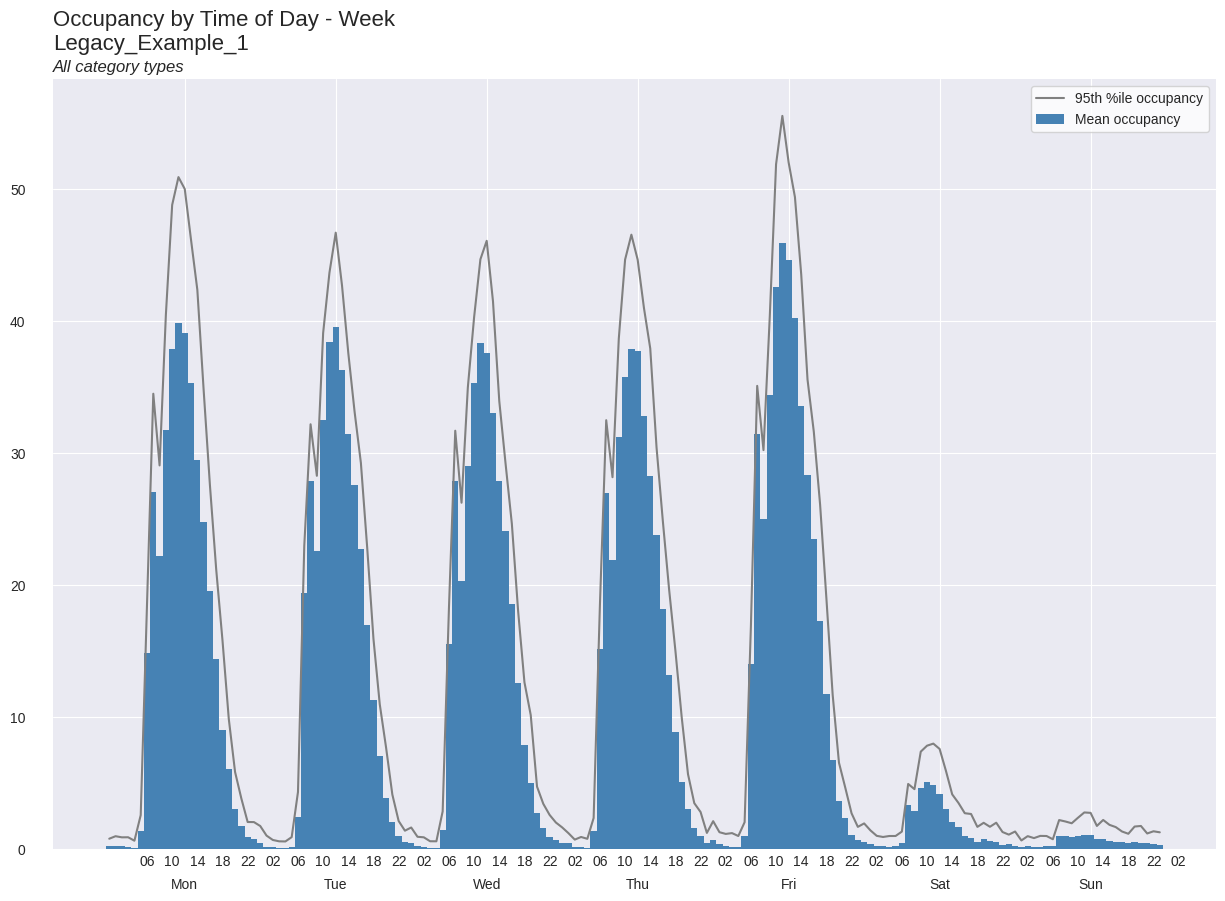

In [40]:
plot = hm.get_plot(hills_legacy_example_1, 'o', 'week')
plot

## Usage example 3 - the CLI

I updated some of the names of the input arguments to match the current arguments used by the `Scenario` model.



In [41]:
!hillmaker --help

usage: hillmaker [--scenario SCENARIO] [--stop_data_csv STOP_DATA_CSV]
                 [--in_field IN_FIELD] [--out_field OUT_FIELD]
                 [--start_analysis_dt START_ANALYSIS_DT]
                 [--end_analysis_dt END_ANALYSIS_DT] [--config CONFIG]
                 [--cat_field CAT_FIELD] [--bin_size_mins BIN_SIZE_MINS]
                 [--occ_weight_field OCC_WEIGHT_FIELD] [--edge_bins EDGE_BINS]
                 [--output_path OUTPUT_PATH] [--export_all_week_plots]
                 [--export_all_dow_plots] [--xlabel XLABEL] [--ylabel YLABEL]
                 [--verbosity VERBOSITY] [--cap CAP]
                 [--percentiles [PERCENTILES ...]]
                 [--cats_to_exclude [CATS_TO_EXCLUDE ...]] [-h]

Occupancy analysis by time of day and day of week

required arguments (either on command line or via config file):
  --scenario SCENARIO   Used in output filenames
  --stop_data_csv STOP_DATA_CSV
                        Path to csv file containing the stop data to be


In [46]:
!hillmaker --scenario_name cli_example_1 --stop_data_csv '../data/ShortStay.csv' \
--in_field 'InRoomTS' --out_field 'OutRoomTS' --cat_field 'PatType' \
--start_analysis_dt '1996-01-01' --end_analysis_dt '1996-09-30' \
--export_all_dow_plots --export_all_week_plots --output_path './output' --verbosity 1

2023-08-23 21:03:15,532 - hillmaker.bydatetime - INFO - min of intime: 1996-01-01 07:44:00
2023-08-23 21:03:15,532 - hillmaker.bydatetime - INFO - max of intime: 1996-09-29 19:51:00
2023-08-23 21:03:15,532 - hillmaker.bydatetime - INFO - min of outtime: 1996-01-01 08:50:00
2023-08-23 21:03:15,532 - hillmaker.bydatetime - INFO - max of outtime: 1996-09-29 20:15:00
2023-08-23 21:03:15,532 - hillmaker.bydatetime - INFO - start analysis: 1996-01-01, end analysis: 1996-09-30
2023-08-23 21:03:15,544 - hillmaker.bydatetime - INFO - min of entry time_bin = 7
2023-08-23 21:03:15,544 - hillmaker.bydatetime - INFO - max of exit time_bin = 6546 and num_bins=6553
2023-08-23 21:03:16,164 - hillmaker.bydatetime - INFO - cat IVT {'inner': 33019}
2023-08-23 21:03:16,209 - hillmaker.bydatetime - INFO - cat IVT num_arrivals_hm 33019 num_arrivals_stops 33019
2023-08-23 21:03:16,209 - hillmaker.bydatetime - INFO - cat IVT num_departures_hm 33019 num_departures_stops 33019
2023-08-23 21:03:16,210 - hillmake